<a href="https://colab.research.google.com/github/logikon-ai/logikon/blob/main/examples/metrics_artifacts_zoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Logikon `/\/`** – Metrics and Artifacts Zoo

*Analyzing and Evaluating LLM Reasoning Traces*

This notebook showcases the reasoning **metrics** and **artifacts** that can be generated with the `logikon` python library.

We're using 🤗's lightweight `zephyr-7b-beta` in this demo for its speed and small footprint. It tends to produce argumentative analyses that are creative and eloquent, rather than rigorous and exact -- and may hence not be the optimal expert model for your use cases.

> ⚠️ **Important notice.**
>
> **Logikon `/\/`** is in early development stage:
> * the package is subject to change at any time;
> * results can vary due to changes in methods, pipelines, or underlying models;
> * current speed and quality of evaluation results are not representative of future product.


**Table of contents**

1. [Set-up](#set-up)
2. [Collect metrics and artifacts](#collect)
3. [Run analysis](#run)
4. [Inspect results](#inspect)

## Set-up environment and examples <a name="set-up"></a>

In [1]:
# Please make sure that the following files from the `examples` folder
# in the `logikon-ai/logikon` GitHub repo are available.
!test -f "requirements.txt" || echo "Missing requirements.txt"
!test -f "setup.sh" || echo "Missing setup.sh"
!test -f "scoring.py" || echo "Missing scoring.py"

In [2]:
# Configure the environment
import os

os.environ["LGK_FRAMEWORK"] = "llamacpp"
os.environ["LGK_DEVICE"] = "gpu"
os.environ["LGK_HUBREPO"] = "TheBloke/zephyr-7B-beta-GGUF"
os.environ["LGK_MODELWEIGHTS"] = "zephyr-7b-beta.Q6_K.gguf"
os.environ["LGK_TOKENIZER"] = "HuggingFaceH4/zephyr-7b-beta"
os.environ["LGK_RELEASE"] = "main"

In [3]:
# Check gpu available
! [ "$LGK_DEVICE" = "gpu" ] && nvidia-smi

Sat Nov 11 15:09:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sh setup.sh

In [6]:
import os

if os.environ.get("LGK_MODELWEIGHTS"):
  abspath = os.path.join(
    os.path.abspath("./models"),
    os.environ.get("LGK_MODELWEIGHTS")
  )
else:
  abspath = ""
os.environ["LGK_ABSPATH_MODELWEIGHTS"] = abspath
os.environ["LGK_ABSPATH_MODELWEIGHTS"]

'/content/models/zephyr-7b-beta.Q6_K.gguf'

In [7]:
# Check whether model weights file is available
!test -f "$LGK_ABSPATH_MODELWEIGHTS" || echo "Cannot find model weights"

In [8]:
# Example reasoning traces

EXAMPLE = {
  "prompt": """Can you give me some advice on whether I should use Vim or Emacs?""",
  "completion": """
The choice between Vim and Emacs is a classic debate in the world of text editors and integrated
development environments (IDEs). Both Vim and Emacs are powerful and highly customizable, but they
have different philosophies and approaches to text editing. Your choice should depend on your
specific needs and preferences. Here's a careful analysis of both editors:

Vim:

Modal Editing: Vim uses a modal editing approach, which means it has different modes for different
tasks (insert mode, normal mode, visual mode, etc.). This can be more efficient for many users once
they become proficient, as it minimizes the need for extensive keyboard shortcuts.

Lightweight: Vim is known for its minimalistic design and lightweight footprint. It can run
efficiently on even older hardware and over SSH connections, making it an excellent choice for
remote server editing.

Highly Efficient for Editing: Once you've mastered Vim, it can be incredibly efficient for text
editing and code navigation. Vim users often rave about its speed and precision.

Emacs:

Extensible: Emacs is known for its extensibility. It's not just a text editor; it's an extensible
platform that can be turned into a full-fledged IDE or customized for any purpose. If you like the
idea of a highly customized environment, Emacs is a strong contender.

Moderate Learning Curve: Emacs has a learning curve, but it may be perceived as less steep than Vim's
for some users. The keybindings are more traditional, and it offers a range of graphical menus that
can help beginners.

Resource Intensive: Emacs can be more resource-intensive compared to Vim. It may not be the best
choice for extremely resource-constrained environments.""",
}

In [9]:
import pandas as pd
df_traces = pd.DataFrame([EXAMPLE])

In [10]:
# Save reasoning traces to file
df_traces.to_json("reasoning_traces.jsonl", orient="records", lines=True)

In [11]:
# Check data file available
!head -2 "reasoning_traces.jsonl"

{"prompt":"Can you give me some advice on whether I should use Vim or Emacs?","completion":"\nThe choice between Vim and Emacs is a classic debate in the world of text editors and integrated\ndevelopment environments (IDEs). Both Vim and Emacs are powerful and highly customizable, but they\nhave different philosophies and approaches to text editing. Your choice should depend on your\nspecific needs and preferences. Here's a careful analysis of both editors:\n\nVim:\n\nModal Editing: Vim uses a modal editing approach, which means it has different modes for different\ntasks (insert mode, normal mode, visual mode, etc.). This can be more efficient for many users once\nthey become proficient, as it minimizes the need for extensive keyboard shortcuts.\n\nLightweight: Vim is known for its minimalistic design and lightweight footprint. It can run\nefficiently on even older hardware and over SSH connections, making it an excellent choice for\nremote server editing.\n\nHighly Efficient for Edit

## Collect all available metrics and artifacts <a name="collect"></a>

In [12]:
# Metrics and artifacts are created by analysts, which are centrally registered

import logikon
import pprint

registry = logikon.analysts.registry.get_analyst_registry()

In [13]:
# List all metrics

mdl = []

mdl.append(f"## Logikon `/\/` Metrics ({logikon.__version__})")
mdl.append("")

for key, analyst_classes in registry.items():
  for analyst_class in analyst_classes:
    if issubclass(analyst_class, logikon.analysts.base.AbstractScoreAnalyst):
      mdl.append(f"#### Metric `{key}`")
      mdl.append("")
      mdl.append(f"* *Description*: {analyst_class.get_description()}")
      mdl.append(f"* *Requirements*: {analyst_class.get_requirements()}")
    mdl.append("")

from IPython.core.display import Markdown
display(Markdown("\n".join(mdl)))

## Logikon `/\/` Metrics (0.0.1-dev1)








#### Metric `argmap_size`

* *Description*: Measure the size of the argument map (number of nodes)
* *Requirements*: [{'fuzzy_argmap_nx'}, {'networkx_graph'}]

#### Metric `n_root_nodes`

* *Description*: Cont the number of root nodes in argument map (out degree = 0)
* *Requirements*: [{'fuzzy_argmap_nx'}, {'networkx_graph'}]

#### Metric `argmap_avg_katz_centrality`

* *Description*: Average Katz centrality of all nodes in the graph
* *Requirements*: [{'fuzzy_argmap_nx'}, {'networkx_graph'}]

#### Metric `argmap_attack_ratio`

* *Description*: Ratio of attacking reasons (cons) in the informal argmap
* *Requirements*: [{'fuzzy_argmap_nx'}, {'networkx_graph'}]

#### Metric `mean_root_support`

* *Description*: The mean root support in the argument map (global balance score)
* *Requirements*: [{'fuzzy_argmap_nx'}, {'networkx_graph'}]

#### Metric `mean_absolute_root_support`

* *Description*: The mean absolute root support in the argument map (local balance score)
* *Requirements*: [{'fuzzy_argmap_nx'}, {'networkx_graph'}]

#### Metric `global_balance`

* *Description*: The argument map's global balance (assumes mutually exclusive and collectively exhaustive root claims)
* *Requirements*: [{'fuzzy_argmap_nx'}, {'networkx_graph'}]

#### Metric `mean_reason_strength`

* *Description*: Mean strength (absolute weight) of support and attack reasons (cons) in the fuzzy argmap
* *Requirements*: [{'fuzzy_argmap_nx'}, {'networkx_graph'}]


In [14]:
# List all artifacts

mdl = []

mdl.append(f"## Logikon `/\/` Artifacts ({logikon.__version__})")
mdl.append("")

for key, analyst_classes in registry.items():
  for analyst_class in analyst_classes:
    if issubclass(analyst_class, logikon.analysts.base.AbstractArtifactAnalyst):
      mdl.append(f"#### Artifact `{key}`")
      mdl.append("")
      mdl.append(f"* *Description*: {analyst_class.get_description()}")
      mdl.append(f"* *Requirements*: {analyst_class.get_requirements()}")
    mdl.append("")


from IPython.core.display import Markdown
display(Markdown("\n".join(mdl)))

## Logikon `/\/` Artifacts (0.0.1-dev1)

#### Artifact `issue`

* *Description*: Issue or decision problem addressed in the deliberation
* *Requirements*: []

#### Artifact `proscons`

* *Description*: Pros and cons list with multiple root claims
* *Requirements*: ['issue']

#### Artifact `relevance_network`

* *Description*: Relevance network describing comprehensively the strengths of pairwise support and attack relations
* *Requirements*: ['issue', 'proscons']

#### Artifact `relevance_network_nx`

* *Description*: Relevance network rendered as a networkx graph
* *Requirements*: ['relevance_network']

#### Artifact `fuzzy_argmap_nx`

* *Description*: Informal argument map (nx graph) with weighted support and attack relations
* *Requirements*: ['relevance_network_nx']

#### Artifact `svg_argmap`

* *Description*: Exports a networkx graph as a graphviz argument map (svg)
* *Requirements*: [{'fuzzy_argmap_nx'}, {'networkx_graph'}]

#### Artifact `html_sunburst`

* *Description*: Exports a networkx graph as a HTML sunburst
* *Requirements*: [{'fuzzy_argmap_nx', 'issue'}, {'issue', 'networkx_graph'}]










In [ ]:
# Write config als yaml file

config_dict = {
    # all metrics
    "metrics": [
        k for k,v in registry.items()
        if issubclass(v[0], logikon.analysts.base.AbstractScoreAnalyst)
    ],
    # artifacts to generate
    "artifacts": [
        k for k,v in registry.items()
        if issubclass(v[0], logikon.analysts.base.AbstractArtifactAnalyst)
    ],
    "global_kwargs": {
        "expert_model": os.environ["LGK_ABSPATH_MODELWEIGHTS"],
        "expert_model_kwargs": {
            "n_ctx": 3072,
            # comment out line below if no gpu
            "n_gpu_layers": -1,
            "tokenizer": os.environ["LGK_TOKENIZER"],
            # custom prompt template, make sure this fits the expert_model
            "prompt_template": {
                "sys_start": "\n<|system|>\n",
                "sys_end": "",
                "user_start": "\n<|user|>\n",
                "user_end": "",
                "ass_start": "\n<|assistant|>\n",
                "ass_end": "",
            },
        },
        "generation_kwargs": {"max_len": 3072},
        "llm_framework": "llama.cpp",
    },
}

import yaml
with open('config.yml', 'w') as outfile:
    yaml.dump(config_dict, outfile, default_flow_style=False)

# Check config file available
!head -10 "config.yml" && echo "..."

## Run analysis <a name="run"></a>

In [16]:
# 🫖 This will take some time ... you may monitor `scoring.log`
!python scoring.py \
  --config-file config.yml \
  --reasoning-traces-file reasoning_traces.jsonl

0it [00:00, ?it/s]The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.

0it [00:00, ?it/s]
/usr/bin/dot

(…)-beta/resolve/main/tokenizer_config.json: 100% 1.43k/1.43k [00:00<00:00, 7.42MB/s]

tokenizer.model: 100% 493k/493k [00:00<00:00, 9.96MB/s]

(…)phyr-7b-beta/resolve/main/tokenizer.json: 100% 1.80M/1.80M [00:00<00:00, 21.9MB/s]

(…)r-7b-beta/resolve/main/added_tokens.json: 100% 42.0/42.0 [00:00<00:00, 289kB/s]

(…)eta/resolve/main/special_tokens_map.json: 100% 168/168 [00:00<00:00, 1.25MB/s]
[Loading llama.cpp model from llama.cpp:/content/models/zephyr-7b-beta.Q6_K.gguf  with  {'n_ctx': 3072, 'n_gpu_layers': -1} ]
2023-11-11 15:49:14.796972: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has alrea

## Inspect generated metrics and artifacts <a name="inspect"></a>

In [18]:
df_scores = pd.read_json("outputs/reasoning_traces-scores.jsonl", lines=True)

### Metrics

In [20]:
# Display metric scores
df_scores[config_dict.get("metrics",[])].T.rename(columns={0: "value"})

,value
argmap_size,15.000000
n_root_nodes,2.000000
argmap_avg_katz_centrality,0.256013
argmap_attack_ratio,0.153846
mean_root_support,0.699909
mean_absolute_root_support,0.699909
global_balance,0.253621
mean_reason_strength,0.868988


### Artifacts

In [98]:
from pprint import pformat

import networkx as nx

from IPython.display import SVG, HTML

from logikon.schemas.pros_cons import ProsConsList
from logikon.schemas.argument_mapping import FuzzyArgMap

def render_artifact(artifact_id, data):
  """helper function for rendering artifacts"""

  if "nx" in artifact_id:
    digraph = nx.node_link_graph(data)
    return Markdown(str(digraph))

  if "svg" in artifact_id:
    style = "<style>svg{width:100% !important;height:100% !important;</style>"
    return HTML(style), SVG(data=data)

  if "html" in artifact_id:
    return HTML(data)

  if artifact_id == "proscons":
    proscons = ProsConsList(**data)
    return Markdown(f"`{pformat(proscons)}`")

  if artifact_id == "relevance_network":
    relnet = FuzzyArgMap(**data)
    return Markdown(f"`{pformat(relnet)[:800]} ...`")

  text = str(data)
  text = text[:200] + " ..." if len(text)>200 else text
  return Markdown(f"`{text}`")

## issue

`Should one use Vim or Emacs for text editing and development?`

## proscons

`ProsConsList(roots=[RootClaim(text='Use Vim for text editing and development.', label='Use Vim', pros=[Claim(text='Vim uses modal editing for different tasks, minimizing keyboard shortcuts and promoting efficiency.', label='Modal Editing'), Claim(text='Vim is lightweight and can run efficiently on older hardware and over SSH connections.', label='Lightweight'), Claim(text='Vim is highly efficient for text editing and code navigation once mastered.', label='Highly Efficient for Editing')], cons=[]), RootClaim(text='Use Emacs for text editing and development.', label='Use Emacs', pros=[Claim(text='Emacs is extensible and can be turned into a full-fledged IDE or customized for any purpose.', label='Extensible'), Claim(text='Emacs may have a less steep learning curve compared to Vim due to traditional keybindings and graphical menus.', label='Moderate Learning Curve')], cons=[Claim(text='Emacs may be more resource-intensive compared to Vim and not the best choice for resource-constrained environments.', label='Resource Intensive')])], options=['Use Vim', 'Use Emacs', 'Use other text editors', "Don't use any text editor (?)"])`

## relevance_network

`FuzzyArgMap(nodelist=[ArgMapNode(id='77ed2989-29c4-4172-a4cd-504695b032d9', text='Use Vim for text editing and development.', label='Use Vim', annotations=[], node_type='central_claim'), ArgMapNode(id='cb2ef89b-421b-43bf-9c91-cacddd63d308', text='Vim is highly efficient for text editing and code navigation once mastered.', label='Highly Efficient for Editing', annotations=[], node_type='reason'), ArgMapNode(id='274578a7-75f2-4591-9f5b-7f07a8063712', text='Vim uses modal editing for different tasks.', label='Modal Editing', annotations=[], node_type='reason'), ArgMapNode(id='3996db4b-8850-47e2-90b2-abfa4626b9bf', text='Vim minimizes keyboard shortcuts.', label='Minimizing keyboard shortcuts', annotations=[], node_type='reason'), ArgMapNode(id='aa27986b-8346-4575-8a99-7f3c2ce7d6b6', text='Vi ...`

## relevance_network_nx

DiGraph with 15 nodes and 169 edges

## fuzzy_argmap_nx

DiGraph with 15 nodes and 13 edges

## svg_argmap

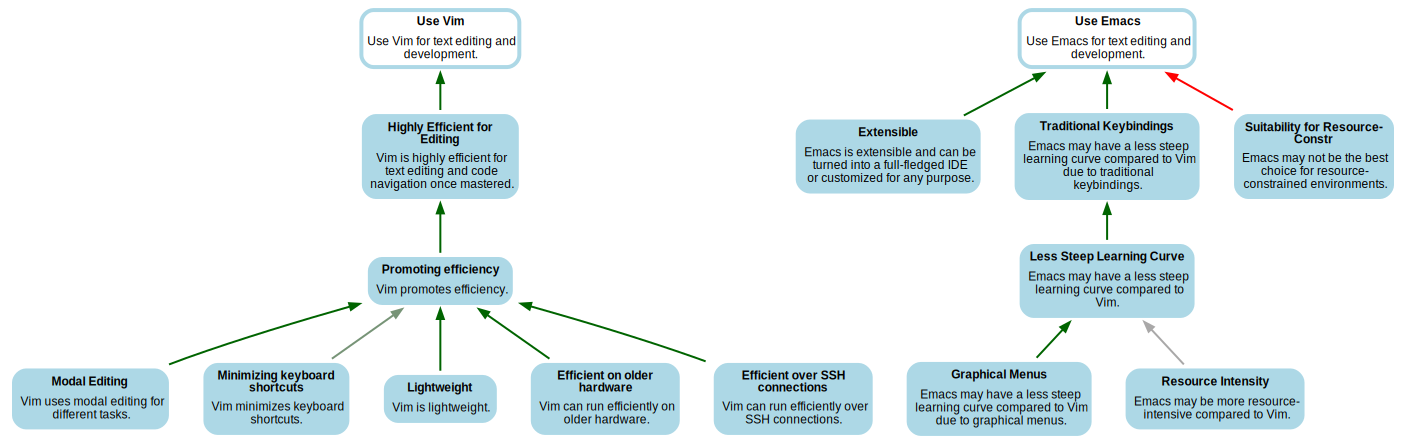

## html_sunburst

In [99]:
from IPython.display import display

for artifact_id in config_dict.get("artifacts",[]):
  display(Markdown(f"## {artifact_id}"))
  data = df_scores.iloc[0].get(artifact_id)
  r = render_artifact(artifact_id, data)
  if isinstance(r, tuple):
    display(*r)
  else:
    display(r)



****

(c) 2023 The Logikon AI Team | License: Apache 2.0